# Homework  <1>

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.io
import scipy

## Exercise 1
Based on Figure 1, the graph will be as below:

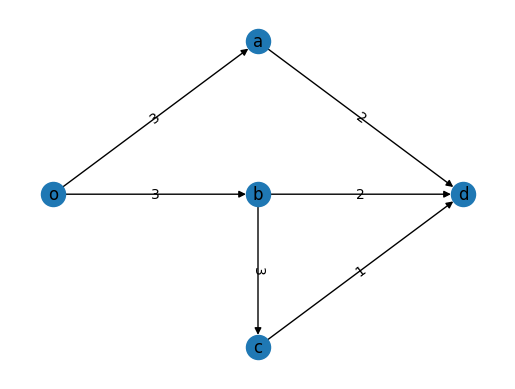

In [2]:
def create_graph():
    G = nx.DiGraph()
    G.add_nodes_from(['o','a','b','c','d'])
    edges = [
        ('o', 'a', {'capacity': 3, 'name': 'e1'}),
        ('o', 'b', {'capacity': 3, 'name': 'e3'}),
        ('a', 'd', {'capacity': 2, 'name': 'e2'}),
        ('b', 'd', {'capacity': 2, 'name': 'e4'}),
        ('b', 'c', {'capacity': 3, 'name': 'e5'}),
        ('c', 'd', {'capacity': 1, 'name': 'e6'})
    ]
    G.add_edges_from(edges)
    return G

def visualize_graph(G):
    positions = {'o': [-1, 0], 'a': [0, 1], 'b': [0, 0], 'c': [0, -1], 'd': [1, 0]}
    edge_labels = nx.get_edge_attributes(G, 'capacity')
    nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels)
    nx.draw(G, positions, with_labels=True)
    plt.show()

G = create_graph()
visualize_graph(G)

### Exercise 1 >> Part a


Graph G has two minimum cuts with  5 capacity:
1. ({'o', 'a'}, {'c', 'b', 'd'})
2. ({'c', 'o', 'b', 'a'}, {'d'})

Our method chooses the second one.

In [3]:
def find_minimum_cut(G, source, target):
    capacity, partitions = nx.algorithms.flow.minimum_cut(G, source, target)
    print(f'"Capacity" of Minimum Cut: {capacity}')
    print(f'"Partitions" of Minimum Cut: {partitions}')

find_minimum_cut(G, 'o', 'd')

"Capacity" of Minimum Cut: 5
"Partitions" of Minimum Cut: ({'o', 'b', 'a', 'c'}, {'d'})


### Exercise 1 >> Part b

First maximum flow must calculated.

In [4]:
def calculate_max_flow(G, source, target):
    max_flow, flows = nx.algorithms.flow.maximum_flow(G, source, target)
    print(f'Maximum Flow: {max_flow}\nList of Flows: {flows}')
    return max_flow, flows

max_flow, flows = calculate_max_flow(G, 'o', 'd')

Maximum Flow: 5
List of Flows: {'o': {'a': 2, 'b': 3}, 'a': {'d': 2}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}


After calculating maximum flow, edges with unused capacity and the total capacity that can be removed (Case 1), and edges with zero flow (Case 2) must identified.

In [5]:
# Case 1 
unused_capacity_edges = []      
total_unused_capacity = 0 
  
for i, j, data in G.edges(data=True):             
    flow = flows[i][j]
    initial_capacity = data['capacity']
    unused_capacity = initial_capacity - flow
    if unused_capacity > 0:
        unused_capacity_edges.append((i, j, unused_capacity))
        total_unused_capacity += unused_capacity

print(f'Edges with unused capacity:{unused_capacity_edges}')   
print(f'Total unused capacity that can be removed: {total_unused_capacity}')

Edges with unused capacity:[('o', 'a', 1), ('b', 'c', 2)]
Total unused capacity that can be removed: 3


In [6]:
# Case 2
no_flow_edges = [(i, j) for i, j, data in G.edges(data=True) if flows[i][j] == 0]    

print(f'Edges with no flow: {no_flow_edges}')
if not no_flow_edges:
    print('No edges can be removed')

Edges with no flow: []
No edges can be removed


### Exercise 1 >> Part c

Distribution x > 0 extra units of capacity in order to maximize the throughput that can be sent from o to d.


Step 0:
Maximum Flow: 5
List of Flows: {'o': {'a': 2, 'b': 3}, 'a': {'d': 2}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}

Step 1:
Maximum Flow: 6
List of Flows: {'o': {'a': 3, 'b': 3}, 'a': {'d': 3}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}
Added 1 capacity to edge a->d

Step 2:
Maximum Flow: 6
List of Flows: {'o': {'a': 3, 'b': 3}, 'a': {'d': 3}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}
Added 2 capacity to edge a->d

Step 3:
Maximum Flow: 7
List of Flows: {'o': {'a': 4, 'b': 3}, 'a': {'d': 4}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}
Added 2 capacity to edge a->d
Added 1 capacity to edge o->a

Step 4:
Maximum Flow: 7
List of Flows: {'o': {'a': 4, 'b': 3}, 'a': {'d': 4}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}
Added 3 capacity to edge a->d
Added 1 capacity to edge o->a

Step 5:
Maximum Flow: 8
List of Flows: {'o': {'a': 5, 'b': 3}, 'a': {'d': 5}, 'b': {'d': 2, 'c': 1}, 'c': {'d': 1}, 'd': {}}
Added 3 capacity to edge a->d
Added 2 capacity to edge o->a

Ste

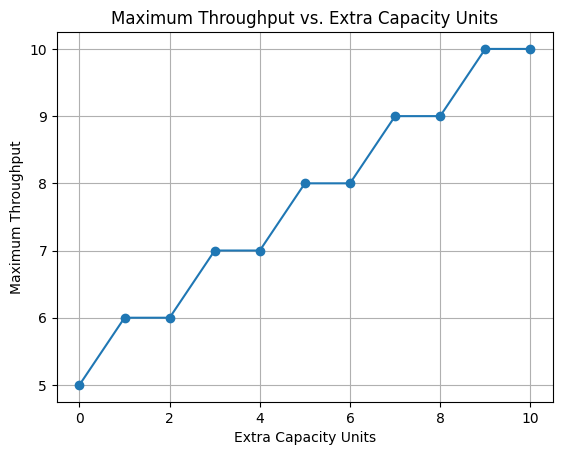

In [7]:
def distribute_extra_capacity_and_plot(G, max_extra_capacity):
    max_throughputs = []

    for extra_capacity in range(max_extra_capacity + 1):
        print(f'\nStep {extra_capacity}:')
        G_new = G.copy()
        added_capacities = {}

        for _ in range(extra_capacity):
            min_cut_value, (partition1, partition2) = nx.minimum_cut(G_new, 'o', 'd')
            linking_edges = [(u, v) for u, v in G_new.edges() if (u in partition1 and v in partition2) or (u in partition2 and v in partition1)]
            if linking_edges:
                edge_to_increment = linking_edges[0]
                if edge_to_increment in added_capacities:
                    added_capacities[edge_to_increment] += 1
                else:
                    added_capacities[edge_to_increment] = 1
                G_new[edge_to_increment[0]][edge_to_increment[1]]['capacity'] += 1

        max_flow, flows = calculate_max_flow(G_new, 'o', 'd')
        max_throughputs.append(max_flow)
        
        for edge, added_capacity in added_capacities.items():
            print(f'Added {added_capacity} capacity to edge {edge[0]}->{edge[1]}')


    # Plot the maximum throughput as a function of extra capacity
    plt.figure()
    plt.plot(range(max_extra_capacity + 1), max_throughputs, marker='o')
    plt.xlabel('Extra Capacity Units')
    plt.ylabel('Maximum Throughput')
    plt.title('Maximum Throughput vs. Extra Capacity Units')
    plt.grid(True)
    plt.show()

# Define the maximum extra capacity to test
max_extra_capacity = 10

distribute_extra_capacity_and_plot(G, max_extra_capacity)

## Exercise 2

There are a set of people {p1,p2,p3,p4} and a set of books {b1,b2,b3,b4}. The interested of persons toward books are like below:

p1 →{b1,b2}, p2 →{b2,b3}, p3 →{b1,b4}, p4 →{b1,b2,b4}

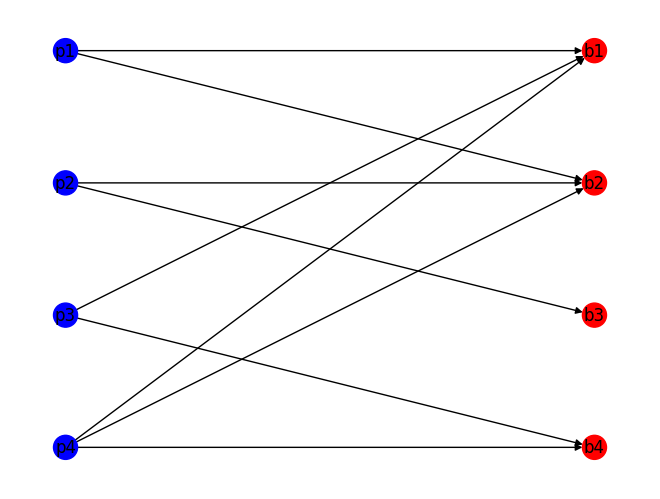

In [8]:
N = nx.DiGraph()
N.add_edges_from([('p1','b1'), ('p1','b2'), ('p2','b2'), ('p2','b3'), ('p3','b1'), ('p3','b4'),('p4','b1'), ('p4','b2'), ('p4','b4')])

position = {'p1':[-1,2], 'p2':[-1,1], 'p3':[-1,0], 'p4':[-1,-1], 'b1':[1,2], 'b2':[1,1], 'b3':[1,0], 'b4':[1,-1]}

node_colors = [
    'blue' if node.startswith('p') else 
    'red' if node.startswith('b') else 
    'green'
    for node in N.nodes()
]
nx.draw(N, position, with_labels=True, node_color=node_colors)
plt.show()

### Exercise 2 >> Part a

Exploiting max-flow problems to find a perfect matching.

Best Matches: [('p1', 'b2'), ('p2', 'b3'), ('p3', 'b1'), ('p4', 'b4')]
(Maximum flow value): 4


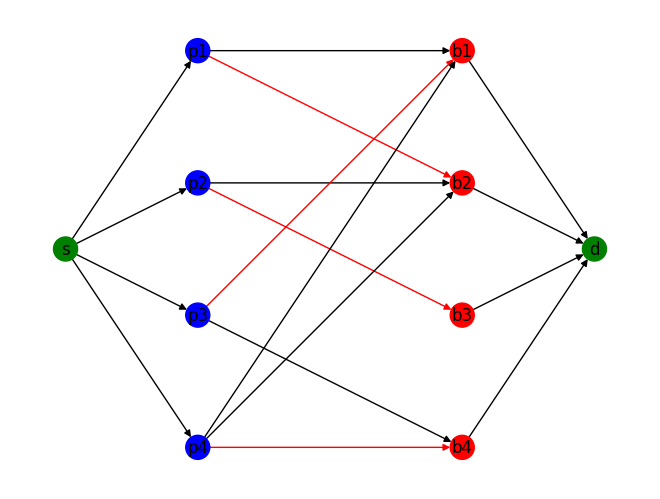

In [9]:
N = nx.DiGraph()
N.add_edges_from([
        ('p1', 'b1', {'capacity': 1}), ('p1', 'b2', {'capacity': 1}),
        ('p2', 'b2', {'capacity': 1}), ('p2', 'b3', {'capacity': 1}),
        ('p3', 'b1', {'capacity': 1}), ('p3', 'b4', {'capacity': 1}),
        ('p4', 'b1', {'capacity': 1}), ('p4', 'b2', {'capacity': 1}), 
        ('p4', 'b4', {'capacity': 1}),
        ('s', 'p1', {'capacity': 1}), ('s', 'p2', {'capacity': 1}),      # 's' is source node.
        ('s', 'p3', {'capacity': 1}), ('s', 'p4', {'capacity': 1}),
        ('b1', 'd', {'capacity': 1}), ('b2', 'd', {'capacity': 1}),      # 'd' is destination node.
        ('b3', 'd', {'capacity': 1}), ('b4', 'd', {'capacity': 1})
    ])

def visualize_graph(N, edge_colors=None, show_labels=False):
    position = {
        'p1': [-1, 2], 'p2': [-1, 1], 'p3': [-1, 0], 'p4': [-1, -1], 
        'b1': [1, 2], 'b2': [1, 1], 'b3': [1, 0], 'b4': [1, -1],
        's': [-2, 0.5], 'd': [2, 0.5]
    }
    if edge_colors is None:
        edge_colors = ['black'] * len(N.edges)
    node_colors = ['blue' if node.startswith('p') else 'red' if node.startswith('b') else 'green' for node in N.nodes()]
    nx.draw(N, position, with_labels=True, edge_color=edge_colors, node_color=node_colors)
    
    if show_labels:
        labels = nx.get_edge_attributes(N, 'capacity')
        nx.draw_networkx_edge_labels(N, position, edge_labels=labels)
    
    plt.show()


max_flow_value_N, flows = nx.algorithms.flow.maximum_flow(N, 's', 'd')

# Finding the edges with flow = 1 (matched pairs)
list_of_edges = []
edge_colors = []
for firstNode in flows:
    for secondNode, flow in flows[firstNode].items():
        if flow == 1 and firstNode != 's' and secondNode != 'd': 
            list_of_edges.append((firstNode, secondNode))
            edge_colors.append('red') 
        else:
            edge_colors.append('black')

print(f'Best Matches: {list_of_edges}')
print(f'(Maximum flow value): {max_flow_value_N}')

visualize_graph(N, edge_colors, show_labels=False)



### Exercise 2 >> Part b

Assume now that there are multiple copies books, and the distribution of the number of
copies is (2; 3; 2; 2). Each person can take an arbitrary number of dierent books. Exploit
the analogy with max-
ow problems to establish how many books of interest can be assigned
in total.

Up to 8 books of interest can be assigned (Maximum flow value).


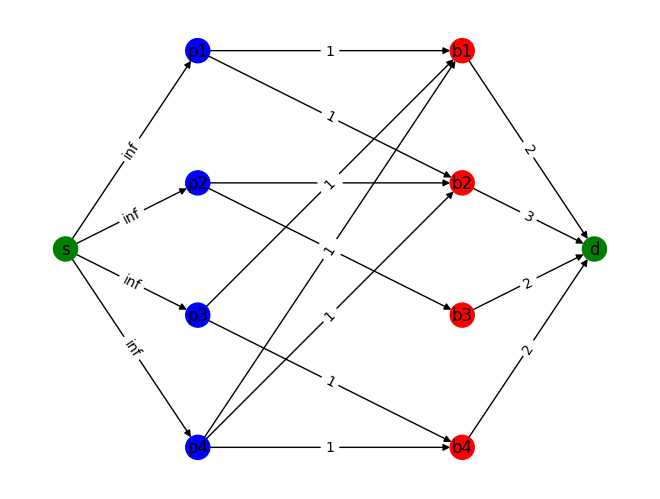

In [10]:
N_new = nx.DiGraph()
N_new.add_edges_from([
        ('p1', 'b1', {'capacity': 1}), ('p1', 'b2', {'capacity': 1}),
        ('p2', 'b2', {'capacity': 1}), ('p2', 'b3', {'capacity': 1}),
        ('p3', 'b1', {'capacity': 1}), ('p3', 'b4', {'capacity': 1}),
        ('p4', 'b1', {'capacity': 1}), ('p4', 'b2', {'capacity': 1}), 
        ('p4', 'b4', {'capacity': 1}),
        ('s', 'p1', {'capacity': float('inf')}), ('s', 'p2', {'capacity': float('inf')}),
        ('s', 'p3', {'capacity': float('inf')}), ('s', 'p4', {'capacity': float('inf')}),
        ('b1', 'd', {'capacity': 2}), ('b2', 'd', {'capacity': 3}),
        ('b3', 'd', {'capacity': 2}), ('b4', 'd', {'capacity': 2})
    ])


max_flow_value_N_new, flows = nx.algorithms.flow.maximum_flow(N_new,'s','d')
print(f'Up to {max_flow_value_N_new} books of interest can be assigned (Maximum flow value).')

visualize_graph(N_new, show_labels=True)

### Exercise 2 >> Part c

Suppose that the library can sell a copy of a book and buy a copy of another book. Which
books should be sold and bought to maximize the number of assigned books?

It's important to recognize that if we have surplus copies of a book, we can sell them, and if we have a deficit, we should buy additional copies. Once these adjustments are made, the maximum flow value will be '9'.

In [11]:
for node in ['b1', 'b2', 'b3', 'b4', 'd']:
    in_flow = sum(flow for u, v, flow in N_new.in_edges(node, data='capacity') if 'capacity' in N_new[u][v])
    out_flow = sum(flow for u, v, flow in N_new.out_edges(node, data='capacity') if 'capacity' in N_new[u][v])

    difference = in_flow - out_flow
    if node in ['b1', 'b2', 'b3', 'b4']:
        if difference > 0:
            print(f'Sold Item: {abs(difference)} of {node} book.')
        elif difference < 0:
            print(f'Bought Item: {abs(difference)} of {node} book.')

Sold Item: 1 of b1 book.
Bought Item: 1 of b3 book.


# Exercise 3

With respect to highway network in Los Angeles city;

Edges starting from node 1: [(1, 2), (1, 6)]
Edges starting from node 2: [(2, 3), (2, 7)]
Edges starting from node 3: [(3, 4), (3, 8), (3, 9)]
Edges starting from node 4: [(4, 5), (4, 9)]
Edges starting from node 5: [(5, 14)]
Edges starting from node 6: [(6, 7), (6, 10)]
Edges starting from node 7: [(7, 8), (7, 10)]
Edges starting from node 8: [(8, 9), (8, 11)]
Edges starting from node 9: [(9, 13), (9, 12)]
Edges starting from node 13: [(13, 14), (13, 17)]
Edges starting from node 14: [(14, 17)]
Edges starting from node 10: [(10, 11), (10, 15)]
Edges starting from node 11: [(11, 12), (11, 15)]
Edges starting from node 15: [(15, 16)]
Edges starting from node 12: [(12, 13)]
Edges starting from node 16: [(16, 17)]


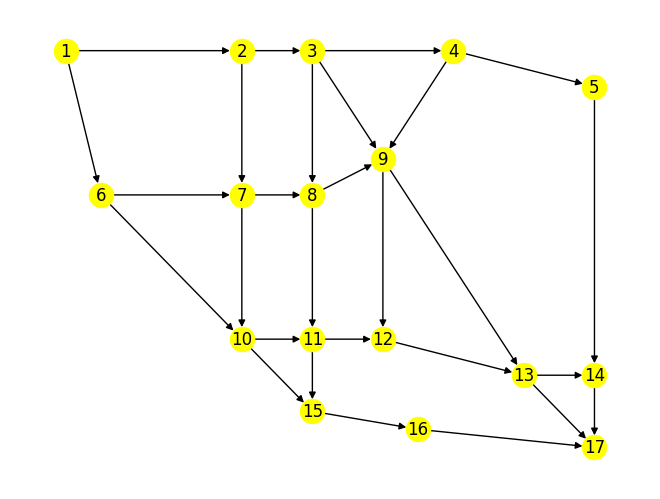

In [2]:
capacities = scipy.io.loadmat('capacities.mat').get('capacities').reshape(28, )
traveltime = scipy.io.loadmat('traveltime.mat').get('traveltime').reshape(28, )
flow_data = scipy.io.loadmat('flow.mat')                       # Will be utilized in part (c)
traffic = scipy.io.loadmat('traffic.mat').get('traffic')

Z = nx.DiGraph()

for edge in range(28):       # Total number of edges are 28.
    capacity = capacities[edge]
    travtime = traveltime[edge]
    for r in range(17):
        if traffic[r][edge] == 1:
            i = r
        if traffic[r][edge] == -1:
            j = r
    Z.add_edges_from([(i + 1, j + 1)], capacity=capacity, traveltime=travtime)

edges = list(Z.edges())
edges_by_start_node = {}

for edge in edges:
    start_node = edge[0]
    if start_node not in edges_by_start_node:
        edges_by_start_node[start_node] = []
    edges_by_start_node[start_node].append(edge)

for start_node, edges in edges_by_start_node.items():
    print(f"Edges starting from node {start_node}: {edges}")


positions = {1: [-3.5, 2], 2: [-1, 2], 3: [0, 2], 4: [2, 2], 5: [4, 1.5],
             6: [-3, 0], 7: [-1, 0], 8: [0, 0], 9: [1, 0.5], 10: [-1, -2],
             11: [0, -2], 12: [1, -2], 13: [3, -2.5], 14: [4, -2.5], 15: [0, -3],
             16: [1.5, -3.25], 17: [4, -3.5]}

node_color = 'yellow'
nx.draw(Z, positions, with_labels=True, node_color=node_color)
plt.show()

### Exercise 3 >> Part a

Identifing the shortest path between node 1 and node 17. This corresponds to the fastest route (the path with the shortest travel time) in an unoccupied network.

In [3]:
shortest_path = nx.shortest_path(Z, 1, 17,'traveltime')
print('Shortest path from Santa Monica (node number 1) to the Santa Ana (node number 17) is: ', shortest_path)

Shortest path from Santa Monica (node number 1) to the Santa Ana (node number 17) is:  [1, 2, 3, 9, 13, 17]


### Exercise 3 >> Part b

Finding the maximum flow between node 1 and 17.

In [4]:
max_flow_value, flows = nx.algorithms.flow.maximum_flow(Z, 1, 17)
print('Maximum flow from node (1) to (17): ', max_flow_value)
print('Flow of the maximum from node (1) to (17):')
for node, flow in flows.items():
    print(f'{node}: {flow}')

Maximum flow from node (1) to (17):  22448
Flow of the maximum from node (1) to (17):
1: {2: 8741, 6: 13707}
2: {3: 8741, 7: 0}
3: {4: 0, 8: 0, 9: 8741}
4: {5: 0, 9: 0}
5: {14: 0}
6: {7: 4624, 10: 9083}
7: {8: 4624, 10: 0}
8: {9: 4624, 11: 0}
9: {13: 6297, 12: 7068}
13: {14: 3835, 17: 10355}
14: {17: 3835}
10: {11: 825, 15: 8258}
11: {12: 825, 15: 0}
15: {16: 8258}
12: {13: 7893}
17: {}
16: {17: 8258}


### Exercise 3 >> Part c

Computing the external inflow $\nu$ satisfying Bf = $\nu$ with respect to the flow vector in flow.mat. 

In the following, we assume that the exogenous inflow is zero in all the nodes except for node 1, for which $\nu_{1}$ has the same value computed in the point (c), and node 17, for which $\nu_{17}$ = -$\nu_{1}$.

In [5]:
# Access and reshape the flow data
flow = flow_data.get('flow').reshape(28, )

np.set_printoptions(precision=2, suppress=True)

number_edges = traffic.shape[1]

exogenous_flow = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1])

l = np.array(traveltime)               # link length vector
f = cp.Variable(number_edges)          # flow vector

objective = cp.Minimize(l.T @ f)
constraints = [exogenous_flow == traffic @ f, f >= 0]
problem = cp.Problem(objective, constraints)

optimal_cost = problem.solve()

optimal_f_formatted = np.array2string(f.value, separator=', ', precision=2, suppress_small=True)
print(f'Optimal f:\n{optimal_f_formatted}')

flow = np.array(flow).flatten()  

external_inflow = traffic @ flow
external_inflow_formatted = np.array2string(external_inflow, separator=', ', precision=2, suppress_small=True)
print(f'External Inflow:\n{external_inflow_formatted}')

Optimal f:
[1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
External Inflow:
[ 16282,   9094,  19448,   4957,   -746,   4768,    413,     -2,  -5671,
   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430, -23544]


### Exercise 3 >> Part d

Find the social optimum $f^∗$ with respect to the delays on the different links $\tau_e$($f_e$). For this,
minimize the cost function


$$
\sum_{e\in E}f_e(\tau_e(f_e) = \sum_{e\in E} \frac {\ f_e l_e }{1 - f_e / c_e}  = \sum_{e\in E} \frac {\ l_e c_e}{1 - f_e / c_e}\, - l_e c_e
$$

subject to the flow constraints.

In [6]:
# Define exogenous inflow vector
exogenous_flow = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

f = cp.Variable(number_edges)

function = cp.sum(cp.multiply(traveltime * capacities, cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - traveltime * capacities)

objective = cp.Minimize(function)
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]  # 0 ≤ fe < ce.
problem = cp.Problem(objective, constraints)

optimal_cost = problem.solve()

optimal_flow = f.value

print("Social Optimal flow:")
for i, value in enumerate(optimal_flow):
    print(f"Flow {i+1}: {value:.2f}")

print(f"\nOptimal Cost: {optimal_cost:.4f}")

Social Optimal flow:
Flow 1: 6642.39
Flow 2: 6059.08
Flow 3: 3132.22
Flow 4: 3132.21
Flow 5: 10163.61
Flow 6: 4638.53
Flow 7: 3006.26
Flow 8: 2542.68
Flow 9: 3131.60
Flow 10: 583.31
Flow 11: 0.10
Flow 12: 2926.76
Flow 13: 0.01
Flow 14: 3132.21
Flow 15: 5525.07
Flow 16: 2854.19
Flow 17: 4886.47
Flow 18: 2215.58
Flow 19: 463.69
Flow 20: 2337.85
Flow 21: 3317.86
Flow 22: 5655.72
Flow 23: 2373.14
Flow 24: 0.01
Flow 25: 6414.17
Flow 26: 5505.35
Flow 27: 4886.48
Flow 28: 4886.48

Optimal Cost: 25943.6270


### Exercise 3 >> Part e

Finding the Wardrop equilibrium $f^0$, with using the below cost function

$$
 \sum_{e \in \mathcal{E}}\int_0^{f_e} \tau_e(s)~\mathrm{d}s.
$$


In [7]:
# Define f
f = cp.Variable(number_edges)

func = cp.sum(- cp.multiply(traveltime * capacities, cp.log(1 - (cp.multiply(f, 1 / capacities)))))

objective = cp.Minimize(func) 

constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]
problem = cp.Problem(objective, constraints) 

wardrop_cost = problem.solve() 

print("Wardrop Equilibrium Flow Vector:")
for i, value in enumerate(f.value):
    print(f"Flow {i + 1}: {value:.2f}")

Wardrop Equilibrium Flow Vector:
Flow 1: 6715.67
Flow 2: 6715.67
Flow 3: 2367.42
Flow 4: 2367.42
Flow 5: 10090.33
Flow 6: 4645.39
Flow 7: 2803.83
Flow 8: 2283.58
Flow 9: 3418.45
Flow 10: 0.00
Flow 11: 176.78
Flow 12: 4171.47
Flow 13: 0.00
Flow 14: 2367.42
Flow 15: 5444.95
Flow 16: 2353.21
Flow 17: 4933.30
Flow 18: 1841.56
Flow 19: 697.02
Flow 20: 3036.60
Flow 21: 3050.23
Flow 22: 6086.83
Flow 23: 2586.54
Flow 24: 0.00
Flow 25: 6918.73
Flow 26: 4953.97
Flow 27: 4933.30
Flow 28: 4933.30


### Exercise 3 >> Part f

Introduce tolls, such that the toll on link $ e $ is $ \omega_e = \psi'_e(f^*) - \tau_e(f^*) $. For the considered $ \psi_e(f_e) $, $ \omega_e = f^*_e \tau'_e(f^*) $, where $ f^*_e $ is the flow at the system optimum. Now the delay on link $ e $ is given by $ \tau_e(f_e) + \omega_e $. Compute the new Wardrop equilibrium $ f(\omega) $.

In [8]:
wardrop_vector = f.value

print("Wardrop Equilibrium Flow Vector without tolls:")
wardrop_vector_str = ", ".join([f"Flow {i + 1}: {value:.2f}" for i, value in enumerate(wardrop_vector)])
print(wardrop_vector_str)

def cost(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((traveltime[i] * capacities[i]) / (1 - (value / capacities[i]))) - traveltime[i] * capacities[i])
    return sum(tot)

wardrop_cost = cost(wardrop_vector) 

print(f"\nWardrop Cost without tolls: {wardrop_cost:.2f}")

PoA = wardrop_cost / optimal_cost

print(f"Total Cost without tolls: {wardrop_cost:.2f}")
print(f"Optimal Cost without tolls: {optimal_cost:.2f}")
print(f"Price of Anarchy (PoA) without tolls: {PoA:.10f}")


f = cp.Variable(number_edges)             # flow vector
omega = []                                # omega vector

for i, value in enumerate(optimal_flow):
    omega.append(value * ((capacities[i] * traveltime[i]) / ((capacities[i] - value) ** 2)))

# Define cost function with tolls
func = cp.sum(cp.multiply(omega, f) - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(f, 1 / capacities)))))

objective = cp.Minimize(func)
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

result = prob.solve()
war_vect = f.value

print("\nWardrop Equilibrium Flow Vector with tolls:")
war_vect_str = ", ".join([f"Flow {i + 1}: {value:.2f}" for i, value in enumerate(war_vect)])
print(war_vect_str)

wardrop_cost = cost(war_vect)

print(f"\nWardrop Cost with tolls: {wardrop_cost:.2f}")

PoA = wardrop_cost / optimal_cost

print(f"Total Cost with tolls: {wardrop_cost:.2f}")
print(f"Optimal Cost with tolls: {optimal_cost:.2f}")
print(f"Price of Anarchy (PoA) with tolls: {PoA:.10f}")

Wardrop Equilibrium Flow Vector without tolls:
Flow 1: 6715.67, Flow 2: 6715.67, Flow 3: 2367.42, Flow 4: 2367.42, Flow 5: 10090.33, Flow 6: 4645.39, Flow 7: 2803.83, Flow 8: 2283.58, Flow 9: 3418.45, Flow 10: 0.00, Flow 11: 176.78, Flow 12: 4171.47, Flow 13: 0.00, Flow 14: 2367.42, Flow 15: 5444.95, Flow 16: 2353.21, Flow 17: 4933.30, Flow 18: 1841.56, Flow 19: 697.02, Flow 20: 3036.60, Flow 21: 3050.23, Flow 22: 6086.83, Flow 23: 2586.54, Flow 24: 0.00, Flow 25: 6918.73, Flow 26: 4953.97, Flow 27: 4933.30, Flow 28: 4933.30

Wardrop Cost without tolls: 26292.97
Total Cost without tolls: 26292.97
Optimal Cost without tolls: 25943.63
Price of Anarchy (PoA) without tolls: 1.0134653613

Wardrop Equilibrium Flow Vector with tolls:
Flow 1: 6641.65, Flow 2: 6058.76, Flow 3: 3132.55, Flow 4: 3132.55, Flow 5: 10164.35, Flow 6: 4637.47, Flow 7: 3006.14, Flow 8: 2542.29, Flow 9: 3131.40, Flow 10: 582.89, Flow 11: 0.00, Flow 12: 2926.21, Flow 13: 0.00, Flow 14: 3132.55, Flow 15: 5526.88, Flow 16:

### Exercise 3 >> Part g

Instead of the total travel time, let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by

$$ \psi_e(f_e) = f_e(\tau_e(f_e) - l_e) $$

subject to the flow constraints. Compute the system optimum $ f^* $ for the costs above. Construct a toll vector $ \omega^* $ such that the Wardrop equilibrium $ f(\omega^*) $ coincides with $ f^* $. Compute the new Wardrop equilibrium with the constructed tolls $ f(\omega^*) $ to verify your result.

In [12]:
number_edges = 28  

exogenous_flow = np.array([16806, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16806])

f = cp.Variable(number_edges)

func = cp.sum(cp.multiply(cp.multiply(traveltime, capacities), cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - cp.multiply(traveltime, capacities) - cp.multiply(traveltime, f))

objective = cp.Minimize(func)
constraints = [traffic @ f == exogenous_flow, f >= 0, f <= capacities]
prob = cp.Problem(objective, constraints)

optimal_cost = prob.solve()

optimal_flow = f.value
print("Social optimal flow:", optimal_flow)
print("Optimal cost:", optimal_cost)

w = cp.Variable(number_edges)

integral = - cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(optimal_flow, 1 / capacities)))) - cp.multiply(optimal_flow, traveltime) + cp.multiply(w, optimal_flow)
func = cp.sum(integral)

objective = cp.Minimize(func)
constraints = [traffic @ w == exogenous_flow, w >= 0]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Constructed tolls:", w.value)
constr_tolls = w.value

f_new = cp.Variable(number_edges)

func = cp.sum(- cp.multiply(capacities * traveltime, cp.log(1 - (cp.multiply(f_new, 1 / capacities)))) - cp.multiply(f_new, traveltime) + cp.multiply(constr_tolls, f_new))

objective = cp.Minimize(func)
constraints = [traffic @ f_new == exogenous_flow, f_new >= 0, f_new <= capacities]
prob = cp.Problem(objective, constraints)

result_w = prob.solve()

print("Wardrop equilibrium:", f_new.value)

if f_new.value is not None:
    def cost2(f):
        tot = []
        for i, value in enumerate(f):
            tot.append(((traveltime[i] * capacities[i]) / (1 - (value / capacities[i]))) - traveltime[i] * capacities[i] - traveltime[i] * value)
        return sum(tot)

    war_vect = f_new.value
    wardrop_cost = cost2(war_vect)

    print("Wardrop cost:", wardrop_cost)
    PoA = wardrop_cost / optimal_cost
    print("Price of Anarchy:", PoA)

Social optimal flow: [ 6653.26  5774.79  3419.67  3419.66 10152.74  4642.69  3105.79  2662.1
  3009.1    878.47     0.01  2355.12     0.01  3419.66  5510.04  3043.63
  4881.79  2415.38   443.7   2008.13  3487.32  5495.45  2203.84     0.
  6300.7   5623.5   4881.79  4881.79]
Optimal cost: 15095.513637826738
Constructed tolls: [16806.     0.     0.     0.     0.     0. 16806.     0.     0. 16806.
     0.    -0.     0.     0.     0.     0.     0.     0. 16806.     0.
     0.     0.     0. 16806.     0.     0. 16806. 16806.]
Wardrop equilibrium: [ 6730.88  6730.88  4786.17  4786.17 10075.12  4703.07  2659.16  2659.16
  4250.07    -0.       0.01  1944.7      0.    4786.17  5372.05  7415.96
     0.    2043.91    -0.     353.8   7415.96  7769.76  3140.13    -0.
  8879.7   7926.3     -0.      -0.  ]
Wardrop cost: 124371429.49951583
Price of Anarchy: 8238.96638984596
